⚙️ Configurando entorno de Alto Rendimiento...
✅ Dependencias instaladas.
🚀 ACELERADOR DE HARDWARE: Tesla T4

📖 Cargando Dataset...
✅ Datos cargados: 51644 registros.
🎯 Clases detectadas (8): ['AMBIENTALES ' 'APOYO AL CIUDADANO ' 'FISCALIZACION Y DEFENSA CIVIL '
 'FISICA ' 'FISICA(SALUD) ' 'PROTECCION FAMILIAR ' 'SEGURIDAD '
 'TRANSITO Y SEGURIDAD VIAL ']

🤖 Iniciando BERT para vectorización semántica...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Generando Embeddings:   0%|          | 0/807 [00:00<?, ?it/s]


⚖️ Aplicando SMOTE (Synthetic Minority Over-sampling Technique)...
   Conteo antes del balanceo: [10000 10000 10000   109  1106   429 10000 10000]
   Conteo después del balanceo: [10000 10000 10000 10000 10000 10000 10000 10000]
✅ Dataset final aumentado: 80000 muestras.

🧬 Iniciando Algoritmo Genético para diseño de red (AutoML)...
   Evolucionando arquitecturas...


/usr/local/lib/python3.12/dist-packages/pygad/pygad.py:733: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(



🏆 MEJOR ARQUITECTURA ENCONTRADA:
   - Neuronas Capa Oculta: 448
   - Dropout Rate: 0.1070
   - Learning Rate: 0.00273

🔥 Entrenando Modelo Definitivo (Full Training)...


Entrenando:   0%|          | 0/40 [00:00<?, ?it/s]


📊 Generando Reporte Final de Tesis...

REPORT OFICIAL DE METRICAS (V2)
                                precision    recall  f1-score   support

                  AMBIENTALES        0.68      0.83      0.75      1973
           APOYO AL CIUDADANO        0.62      0.53      0.57      1933
FISCALIZACION Y DEFENSA CIVIL        0.80      0.67      0.73      2035
                       FISICA        1.00      1.00      1.00      2007
                FISICA(SALUD)        0.93      0.99      0.96      1976
          PROTECCION FAMILIAR        0.98      1.00      0.99      2047
                    SEGURIDAD        0.70      0.72      0.71      2029
    TRANSITO Y SEGURIDAD VIAL        0.67      0.66      0.66      2000

                      accuracy                           0.80     16000
                     macro avg       0.80      0.80      0.80     16000
                  weighted avg       0.80      0.80      0.80     16000



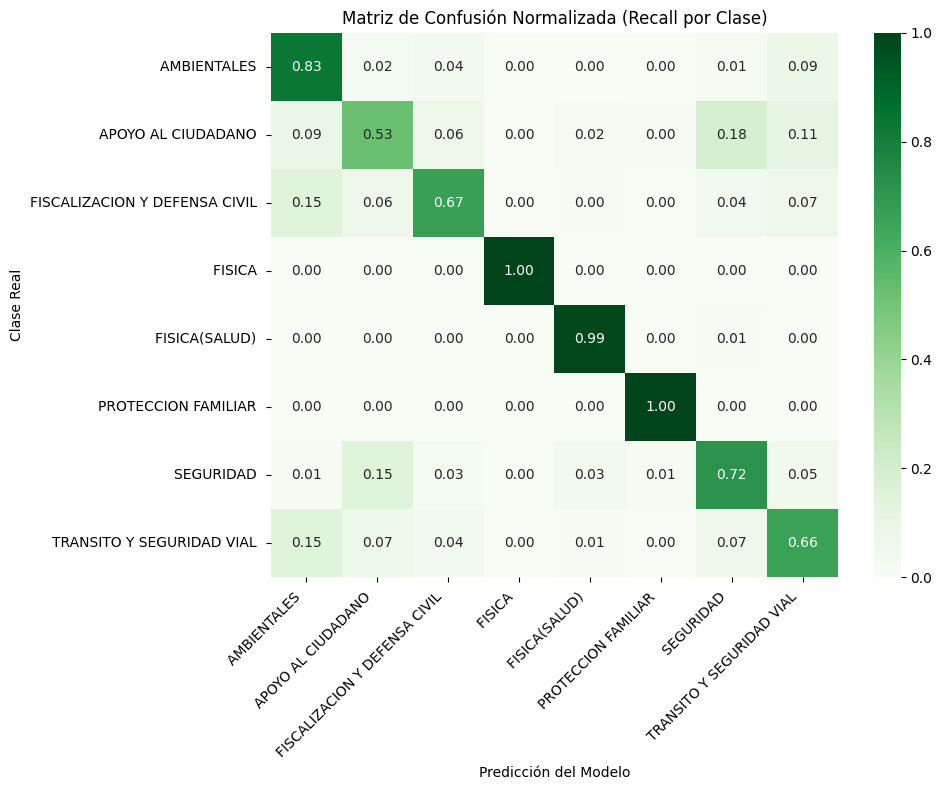

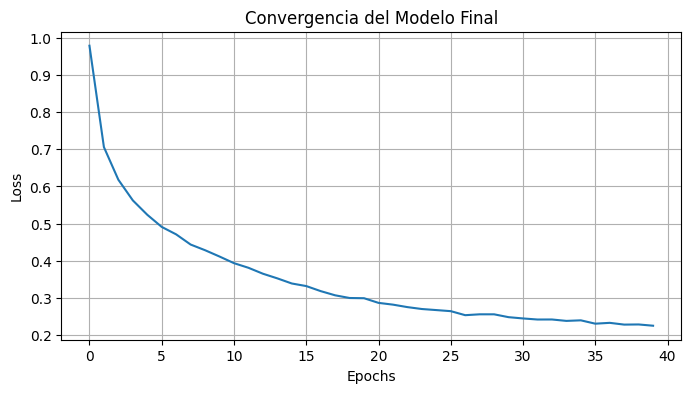

In [1]:
################################################################################
#                                                                              #
#                         PROJECT EVO - VERSION 2.0                            #
#                           ProjectEvo_V2.ipynb                                #
#                                                                              #
################################################################################

# --- PASO 1: INSTALACIÓN DE DEPENDENCIAS (Ejecutar primero) ---
import shutil
import os

print("⚙️ Configurando entorno de Alto Rendimiento...")
if shutil.which("uv") is None:
    !pip install uv -q

# Instalación rápida de librerías necesarias
!uv pip install --system -q \
    torch \
    transformers \
    pygad \
    pandas \
    numpy \
    scikit-learn \
    tqdm \
    imbalanced-learn \
    matplotlib \
    seaborn

print("✅ Dependencias instaladas.")

# --- PASO 2: IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN ---
import torch
import torch.nn as nn
import pygad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel, logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from google.colab import drive
from tqdm.notebook import tqdm

# Configuración Global
logging.set_verbosity_error() # Silenciar alertas de HuggingFace
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 ACELERADOR DE HARDWARE: {torch.cuda.get_device_name(0)}")

# --- PASO 3: CARGA Y PREPROCESAMIENTO DE DATOS ---
# URL del archivo en formato Raw
ruta_github = 'https://raw.githubusercontent.com/berniehans/DataCallao/main/v2_dataset_callao.csv'

print("\n📖 Cargando Dataset...")
df = pd.read_csv(ruta_github, sep=';', encoding='latin1', usecols=['DESCRIPCION_OCURRENCIA', 'TIPOLOGIA'])

# Sampling inteligente (Usamos suficientes datos para que BERT entienda el contexto)
df_sampled = df.groupby('TIPOLOGIA').head(10000).reset_index(drop=True)
if len(df_sampled) < 5000:
    df_sampled = df.sample(min(len(df), 50000), random_state=42)

print(f"✅ Datos cargados: {len(df_sampled)} registros.")

# Codificación de etiquetas
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df_sampled['TIPOLOGIA'])
CLASES_NAMES = encoder.classes_
NUM_CLASSES = len(CLASES_NAMES)
X_text = df_sampled['DESCRIPCION_OCURRENCIA'].astype(str).fillna("").tolist()

print(f"🎯 Clases detectadas ({NUM_CLASSES}): {CLASES_NAMES}")

# --- PASO 4: EXTRACCIÓN DE VECTORES CON BERT (FEATURE EXTRACTION) ---
print("\n🤖 Iniciando BERT para vectorización semántica...")
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
bert_model = BertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased').to(DEVICE)
bert_model.eval()

embeddings_list = []
BATCH_SIZE_BERT = 64

# Procesamiento por lotes
for i in tqdm(range(0, len(X_text), BATCH_SIZE_BERT), desc="Generando Embeddings"):
    batch_text = X_text[i : i + BATCH_SIZE_BERT]
    inputs = tokenizer(batch_text, return_tensors="pt", padding=True, truncation=True, max_length=64).to(DEVICE)
    with torch.no_grad():
        outputs = bert_model(**inputs)
        # Usamos el vector [CLS] como resumen de la frase
        embeddings_list.append(outputs.pooler_output.cpu().numpy())

# Unimos todo en una matriz gigante
X_emb = np.concatenate(embeddings_list, axis=0)

# Limpieza de VRAM (Ya no necesitamos a BERT en memoria)
del bert_model, inputs, outputs
torch.cuda.empty_cache()
gc.collect()

# --- PASO 5: SMOTE (BALANCEO SINTÉTICO) ---
print("\n⚖️ Aplicando SMOTE (Synthetic Minority Over-sampling Technique)...")
print("   Conteo antes del balanceo:", np.bincount(y_encoded))

# Generamos datos sintéticos para las clases minoritarias
smote = SMOTE(random_state=42, k_neighbors=3)
X_res, y_res = smote.fit_resample(X_emb, y_encoded)

print("   Conteo después del balanceo:", np.bincount(y_res))
print(f"✅ Dataset final aumentado: {len(X_res)} muestras.")

# Normalización estándar (Ayuda a la convergencia de la red neuronal)
scaler = StandardScaler()
X_res = scaler.fit_transform(X_res)

# División Train/Test (80/20)
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Convertimos a Tensores de PyTorch y enviamos a GPU
X_train_gpu = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
y_train_gpu = torch.tensor(y_train, dtype=torch.long).to(DEVICE)
X_val_gpu = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
y_val_gpu = torch.tensor(y_val, dtype=torch.long).to(DEVICE)

# --- PASO 6: BÚSQUEDA DE ARQUITECTURA (NEURO-EVOLUCIÓN) ---
print("\n🧬 Iniciando Algoritmo Genético para diseño de red (AutoML)...")

def build_dynamic_model(genes):
    """Construye una red neuronal basada en los genes del GA"""
    n_neurons = int(genes[0]) # Gen 0: Cantidad de neuronas
    drop_rate = genes[1]      # Gen 1: Dropout

    model = nn.Sequential(
        nn.Linear(768, n_neurons),
        nn.BatchNorm1d(n_neurons),
        nn.ReLU(),
        nn.Dropout(drop_rate),
        nn.Linear(n_neurons, NUM_CLASSES)
    ).to(DEVICE)
    return model

def fitness_func(ga_instance, solution, solution_idx):
    # 1. Construir modelo propuesto
    model = build_dynamic_model(solution)
    lr = solution[2] # Gen 2: Learning Rate

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 2. Entrenamiento rápido (Few-Shot)
    model.train()
    # Usamos solo 2000 muestras aleatorias para evaluar rápido
    indices = torch.randperm(len(X_train_gpu))[:2000]

    for _ in range(10): # 10 iteraciones
        optimizer.zero_grad()
        out = model(X_train_gpu[indices])
        loss = criterion(out, y_train_gpu[indices])
        loss.backward()
        optimizer.step()

    # 3. Validar y devolver F1-Macro
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(X_val_gpu), dim=1)
        score = f1_score(y_val_gpu.cpu().numpy(), preds.cpu().numpy(), average='macro')
    return score

# Configuración del GA
gene_space = [
    {'low': 32, 'high': 512, 'step': 32}, # Neuronas
    {'low': 0.1, 'high': 0.6},            # Dropout
    {'low': 0.0001, 'high': 0.01}         # Learning Rate
]

ga_instance = pygad.GA(
    num_generations=15,
    num_parents_mating=3,
    fitness_func=fitness_func,
    sol_per_pop=8,
    num_genes=3,
    gene_space=gene_space,
    parent_selection_type="rws",
    keep_parents=2,
    random_seed=42
)

# Ejecutar Evolución
print("   Evolucionando arquitecturas...")
ga_instance.run()

# Obtener ganador
best_solution = ga_instance.best_solution()[0]
print(f"\n🏆 MEJOR ARQUITECTURA ENCONTRADA:")
print(f"   - Neuronas Capa Oculta: {int(best_solution[0])}")
print(f"   - Dropout Rate: {best_solution[1]:.4f}")
print(f"   - Learning Rate: {best_solution[2]:.5f}")

# --- PASO 7: ENTRENAMIENTO FINAL DEL MODELO GANADOR ---
print("\n🔥 Entrenando Modelo Definitivo (Full Training)...")

final_model = build_dynamic_model(best_solution)
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_solution[2])
criterion = nn.CrossEntropyLoss()

# Entrenamiento completo
EPOCHS = 40
BATCH_SIZE = 128
loss_history = []

final_model.train()
for epoch in tqdm(range(EPOCHS), desc="Entrenando"):
    perm = torch.randperm(len(X_train_gpu))
    epoch_loss = 0

    for i in range(0, len(X_train_gpu), BATCH_SIZE):
        idx = perm[i : i + BATCH_SIZE]
        optimizer.zero_grad()
        outputs = final_model(X_train_gpu[idx])
        loss = criterion(outputs, y_train_gpu[idx])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    loss_history.append(epoch_loss / (len(X_train_gpu)/BATCH_SIZE))

# --- PASO 8: EVALUACIÓN Y REPORTES ---
print("\n📊 Generando Reporte Final de Tesis...")
final_model.eval()

with torch.no_grad():
    outputs = final_model(X_val_gpu)
    y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
    y_true = y_val_gpu.cpu().numpy()

# 1. Reporte de Clasificación
print("\n" + "="*60)
print("REPORT OFICIAL DE METRICAS (V2)")
print("="*60)
print(classification_report(y_true, y_pred, target_names=CLASES_NAMES))

# 2. Matriz de Confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=CLASES_NAMES, yticklabels=CLASES_NAMES)
plt.title("Matriz de Confusión Normalizada (Recall por Clase)")
plt.ylabel("Clase Real")
plt.xlabel("Predicción del Modelo")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Curva de Aprendizaje
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title("Convergencia del Modelo Final")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()